## 掛載雲端硬碟


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 更改檔案所在路徑

In [2]:
# Change to your own folder !!!
%cd /content/drive/MyDrive

/content/drive/MyDrive


## Import library

In [3]:
import os
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from models.resnet import ResNet50


## 設定超參數

In [4]:
SEED = 1
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 40
LEARNING_RATE = 1e-3
LOG_INTERVAL = 100
CUDA = True

RESUME = True
START_EPOCH = 0

PRUNE_PATH = '/content/drive/MyDrive/models/model_prune_0.9.pth' # Change to your own folder !!!
PRUNE_FINETUNE_PATH = '/content/drive/MyDrive/models/model_prune_finetune.pth' # Change to your own folder !!!


#### 檢查是否檢查是否可使用GPU

In [5]:
if(torch.cuda.is_available()):
    CUDA = True
    kwargs = {'num_workers': 1, 'pin_memory': True}
    torch.cuda.manual_seed(SEED)
else:
    CUDA = False
    kwargs = {}


## 下載資料集


這裡將訓練集做Augmentation(Pad, RandCrop, Random)，測試集不用做Augmentation

In [6]:
#### DATASET ####
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.Pad(4),
                       transforms.RandomCrop(32),
                       transforms.RandomHorizontalFlip(),
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                   ])),
    batch_size=TEST_BATCH_SIZE, shuffle=True, **kwargs)

## 載入剪枝後的網路與權重

In [7]:
model = None
if(RESUME):
  checkpoint = torch.load(PRUNE_PATH)
  cfg = checkpoint['cfg']
  model = ResNet50(num_classes=10,cfg=cfg)
  model.load_state_dict(checkpoint['state_dict'])

  print('RESUME PRUNE MODEL')

if CUDA:
    model.cuda()

RESUME PRUNE MODEL


## 設定 Optimizer & CrossEntropy Loss

In [8]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE,weight_decay=1e-5) # Added weight_decay
criterion = nn.CrossEntropyLoss()

## 定義訓練跟測試函數

In [9]:
#### 訓練函數 #####

def train(epoch):
    model.train()

    ##### 新增: 用於計算整個 epoch 的 train acc #####
    train_correct = 0
    train_total = 0
    #############################################

    for batch_idx, (data, target) in enumerate(train_loader):
        if CUDA:
            data, target = data.cuda(), target.cuda()

        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()

        optimizer.step()

        pred = output.data.max(1, keepdim=True)[1]

        ##### 新增: 累加正確數和總數 #####
        train_total += target.size(0)
        train_correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        ###################################

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.1f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    ##### 新增: 計算並回傳此 epoch 的 train acc #####
    epoch_train_acc = 100. * float(train_correct) / float(train_total)
    return epoch_train_acc
    #################################################


#### 測試函數 ####
def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
      for data, target in test_loader:
          if CUDA:
              data, target = data.cuda(), target.cuda()
          data, target = Variable(data), Variable(target)

          output = model(data)
          loss = criterion(output, target)
          test_loss += loss.item() * data.size(0)

          pred = output.data.max(1, keepdim=True)[1]
          correct += pred.eq(target.data.view_as(pred)).cpu().sum()

      test_loss /= len(test_loader.dataset)

      ##### 修改: 計算 test acc (百分比) #####
      test_acc_percent = 100. * float(correct) / float(len(test_loader.dataset))
      ########################################

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          test_acc_percent)) ##### 修改: 使用百分比變數 #####

      return test_acc_percent ##### 修改: 回傳 test acc 百分比 #####

##########################################################################################

best_prec1 = 0.

##### 新增: 準備兩個 list 儲存 acc #####
train_acc_history = []
test_acc_history = []
#######################################

for epoch in range(START_EPOCH, EPOCHS):
    # Learning Rate 在 0.5EPOCHS 與 0.75EPOCHS 調整為原本 1/10
    if epoch in [EPOCHS*0.5, EPOCHS*0.75]:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1

    ##### 修改: 接收 train() 和 test() 回傳的 acc #####
    epoch_train_acc = train(epoch)
    prec1 = test()

    ##### 新增: 將 acc 存入 list #####
    train_acc_history.append(epoch_train_acc)
    test_acc_history.append(prec1)
    #######################################

    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

# (儲存 checkpoint 的程式碼...)
# ...

# 迴圈結束後，你就可以用 train_acc_history 和 test_acc_history 來畫圖了
print("Fine-tuning finished.")
print("Train Accuracy History:", train_acc_history)
print("Test Accuracy History:", test_acc_history)

Train Epoch: 0 [0/50000 (0.0%)]	Loss: 1.007822
Train Epoch: 0 [10000/50000 (20.0%)]	Loss: 0.482089
Train Epoch: 0 [20000/50000 (40.0%)]	Loss: 0.477372
Train Epoch: 0 [30000/50000 (60.0%)]	Loss: 0.484051
Train Epoch: 0 [40000/50000 (80.0%)]	Loss: 0.487108

Test set: Average loss: 0.5130, Accuracy: 8308/10000 (83.1%)

Train Epoch: 1 [0/50000 (0.0%)]	Loss: 0.311674
Train Epoch: 1 [10000/50000 (20.0%)]	Loss: 0.269460
Train Epoch: 1 [20000/50000 (40.0%)]	Loss: 0.301890
Train Epoch: 1 [30000/50000 (60.0%)]	Loss: 0.295869
Train Epoch: 1 [40000/50000 (80.0%)]	Loss: 0.536536

Test set: Average loss: 0.5151, Accuracy: 8371/10000 (83.7%)

Train Epoch: 2 [0/50000 (0.0%)]	Loss: 0.341117
Train Epoch: 2 [10000/50000 (20.0%)]	Loss: 0.390112
Train Epoch: 2 [20000/50000 (40.0%)]	Loss: 0.357494
Train Epoch: 2 [30000/50000 (60.0%)]	Loss: 0.344603
Train Epoch: 2 [40000/50000 (80.0%)]	Loss: 0.449892

Test set: Average loss: 0.4442, Accuracy: 8523/10000 (85.2%)

Train Epoch: 3 [0/50000 (0.0%)]	Loss: 0.278989

## 繪製Fine-tuning結果圖


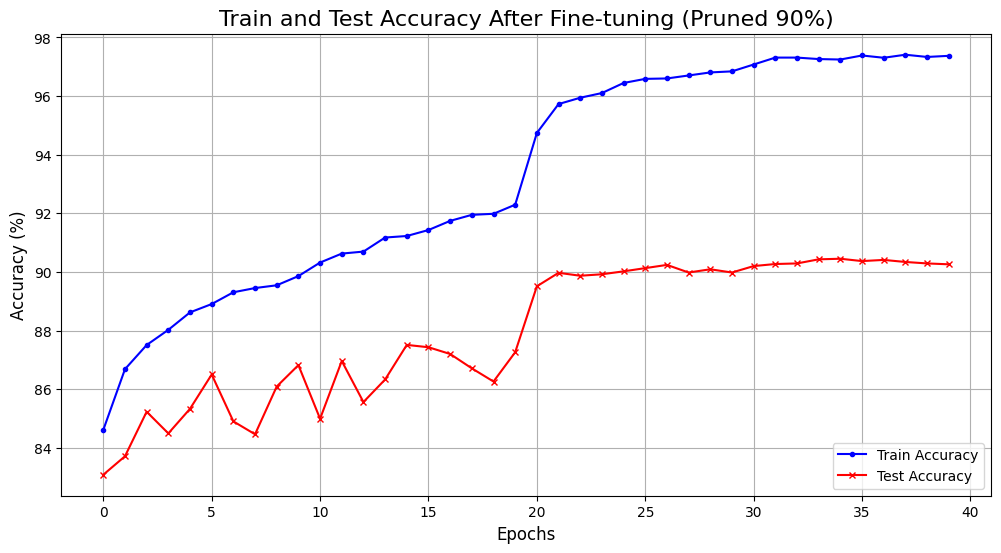

In [10]:
import matplotlib.pyplot as plt

# 獲取總共的 epochs 數量
epochs_range = range(START_EPOCH, EPOCHS)

plt.figure(figsize=(12, 6))

# 繪製 Train Accuracy
plt.plot(epochs_range, train_acc_history, label='Train Accuracy', color='blue', marker='o', markersize=3)

# 繪製 Test Accuracy
plt.plot(epochs_range, test_acc_history, label='Test Accuracy', color='red', marker='x', markersize=5)

plt.title('Train and Test Accuracy After Fine-tuning (Pruned 90%)', fontsize=16)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(loc='lower right') # 將圖例放在右下角
plt.grid(True)
plt.show()

## FLOPs & Parameters

In [11]:
!pip install thop
!pip install torchsummary

In [12]:
from thop import profile
from torchsummary import summary

##### 使用 thop 計算 FLOPs 和參數數量 #####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = model.to(device)

dummy_input = torch.randn(1, 3, 32, 32).to(device)
flops, params = profile(model, inputs=(dummy_input, ))

print(f"FLOPs: {flops}")
print(f"Params: {params}")
summary(model, input_size=(3, 32, 32))

Device: cuda
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 122447508.0
Params: 3665475.0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]           